In [1]:
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import os
import cv2


Define functions that create the image paths (Original/source and training)

In [2]:

def create_source_path(id):     
    return "C:/Users/weime/Documents/Python Scripts/CircularFashion/Data/fashion-dataset/images/"+ str(id) + ".jpg"
def create_training_path(id, extension):     
    return "C:/Users/weime/Documents/Python Scripts/CircularFashion/Data/fashion-dataset/targets/"+ str(id) + extension + ".jpg"

In [3]:
Shirts = pd.read_csv(filepath_or_buffer="C:/Users/weime/Documents/Python Scripts/CircularFashion/Data/fashion-dataset/styles.csv",
            delimiter=",", encoding="utf-8", on_bad_lines = "skip")

Shirts = Shirts[Shirts["articleType"].str.match('.*[Ss]weaters.*|.*[Ss]hirt.*|.*[Ss]uits.*|.*[Jj]ackets.*')]
Shirts

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
...,...,...,...,...,...,...,...,...,...,...
44412,1644,Men,Apparel,Topwear,Tshirts,Red,Fall,2010.0,Sports,Kipsta Men Loose Fit Round Neck Jersey Red
44414,30614,Men,Apparel,Topwear,Tshirts,Black,Summer,2012.0,Sports,Nike Men Striped Black Jersey
44415,13496,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Chimp Men Teja Main Hoon Blue Tshirts
44417,12544,Women,Apparel,Topwear,Tshirts,Peach,Fall,2011.0,Casual,Tantra Women Printed Peach T-shirt


Determine for which images there are labels, in order to use them for training.

In [5]:
training_paths = os.listdir("C:/Users/weime/Documents/Python Scripts/CircularFashion/Data/fashion-dataset/targets")
extension = "_neckline"

training_ids = np.array([int(xi.removesuffix(extension + ".jpg")) for xi in training_paths])
Shirts["training_data"] =  np.array([xi in training_ids for xi in Shirts["id"]])


Create a function that transposes an image. This is done so that classifier will be translation invariant. We could also rotate the images and refelct them, but due to the nature of the immages, this seems not nessecary, especially with the limited time. 

In [6]:
def transpose_img(img, x = 10, y  = 10, mode = "source"): 
    if (mode == "source"): 
        img_new = np.ones(img.shape) 
    else:
        img_new = np.zeros(img.shape)


    x_min     = max(x, 0)
    x_min_new = max(-x, 0)

    x_max     = min(img.shape[0] + x, img.shape[0])
    x_max_new = min(img.shape[0] - x, img.shape[0])

    y_min     = max(y, 0)
    y_min_new = max(-y, 0)

    y_max     = min(img.shape[1] + y, img.shape[1])
    y_max_new = min(img.shape[1] - y, img.shape[1])   

    img_new[x_min_new:x_max_new,y_min_new:y_max_new,:] = img[x_min:x_max,y_min:y_max,:]
    return(img_new)

Create transposed copys of the images used for traning. It is importand that we also transpose the target data. Also due to memory and GPU limits I will rezise the images to 256/256. I also have to split the images into epochs already as they are to large for my RAM. You may adjusst this to your ressources.

In [7]:
TrainingData = Shirts[Shirts["training_data"]]

size = 256 

for epoch in range(2):
    num_tranposition = 5

    # sample the transposition coordinate 
    # for efficiency only sample once but a larger vector
    rand_ints = np.random.randint(low = -50, high = 50, size = TrainingData.shape[0] * num_tranposition * 2)



    # define the training images
    training_images = np.ones(shape = (TrainingData.shape[0] * num_tranposition, 256, 256, 3))
    target_images   = np.ones(shape = (TrainingData.shape[0] * num_tranposition, 256, 256, 3))

    # assign the training immages
    for k in range(TrainingData.shape[0]):

        # read the kth image and resize it
        img_train = mpimg.imread(create_source_path(TrainingData["id"].iat[k])).astype(float) / 255
        img_train = cv2.resize(img_train, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)


        img_target = mpimg.imread(create_training_path(TrainingData["id"].iat[k], extension)).astype(float) / 255
        img_target = cv2.resize(img_target, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)


        # transpose the image num_tranposition times
        for i in range(num_tranposition): 
            # assign the transposed image
            training_images[k * num_tranposition +i,:,:,:] = transpose_img(img_train,
                                                                           rand_ints[num_tranposition * k + i*2],
                                                                           rand_ints[num_tranposition * k + i*2]+1)
            target_images[k * num_tranposition +i,:,:,:]   = transpose_img(img_target, 
                                                                           rand_ints[num_tranposition * k + i*2], 
                                                                           rand_ints[num_tranposition * k + i*2]+1,
                                                                           mode = "other")



    path = "C:/Users/weime/Documents/Python Scripts/CircularFashion/Data/fashion-dataset/prepared-data"

    np.save(path + "/training_images" + str(epoch), training_images)
    np.save(path + "/target_images" + str(epoch), target_images)




Now we have a look at some plots to ensure the transposition worked correctly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


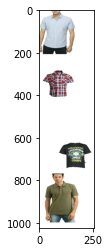

In [8]:
plt.imshow(training_images[0:20:5].reshape(256 * 4,256 ,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


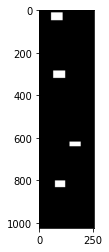

In [9]:
plt.imshow(target_images[0:20:5].reshape(256 * 4,256,3))

Save the modified data in order to use it in the next skript.